# Stroke Prediction

Welcome to The Johns Hopkins Hospital's groundbreaking project. Our mission is clear: to create a machine learning model that predicts stroke risk in patients.

Strokes are life-threatening events, and early detection is vital. This project combines data analysis, machine learning, and medical expertise to develop a tool that identifies high-risk individuals, enabling timely interventions and tailored advice.

In [1]:
%load_ext lab_black

In [2]:
import functions as myFunc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer

import statsmodels.stats.api as sms
from math import ceil
import scipy.stats as stats
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
pd.set_option("float_format", "{:.2f}".format)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [4]:
df = pd.read_csv(
    r"C:\Users\jonyt\Python\3 module\sprint 2\project\healthcare-dataset-stroke-data.csv"
)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,51676,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,60182,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,1665,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1


In [5]:
df.shape

(5110, 12)

## Data clening

In [6]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [7]:
bmi_values = df.loc[:, "bmi"].values.reshape(-1, 1)
imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
df["bmi"] = imputer.fit_transform(bmi_values)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,51676,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,28.89,never smoked,1
2,31112,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,60182,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,1665,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1


In [8]:
df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [9]:
df.duplicated().sum()

0

No duplicates were found including ids. Let's check if there are duplicates ignoring ids values.

In [10]:
df = df.drop(columns="id", axis=1)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,28.89,never smoked,1
2,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1


In [11]:
df.duplicated().sum()

0

**Conclusion**: No dublicates were found. Missing bmi values were filled with mean value.

### Checking data correctness and outliers

In [12]:
df.head(2)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,28.89,never smoked,1


In [13]:
# Categorical features values check
df_for_unique_values = df.drop(columns=["age", "avg_glucose_level", "bmi"])

In [14]:
myFunc.unique_values(df_for_unique_values)

{'gender': ['Male', 'Female', 'Other'],
 'hypertension': [0, 1],
 'heart_disease': [1, 0],
 'ever_married': ['Yes', 'No'],
 'work_type': ['Private',
  'Self-employed',
  'Govt_job',
  'children',
  'Never_worked'],
 'Residence_type': ['Urban', 'Rural'],
 'smoking_status': ['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
 'stroke': [1, 0]}

**Conclusion**: There were no unusual values detected in the categorical features.

In [15]:
# Numeric features values check
df.describe(include=["float64"])

,age,avg_glucose_level,bmi
count,5110.00,5110.00,5110.00
mean,43.23,106.15,28.89
std,22.61,45.28,7.70
min,0.08,55.12,10.30
25%,25.00,77.25,23.80
50%,45.00,91.88,28.40
75%,61.00,114.09,32.80
max,82.00,271.74,97.60


Normal sugar level is between 70 and 100 mg/dL (3.9 and 5.6 mmol/L). Blood sugar levels over 250 mg/dL or below 50 mg/dL are hazardous and needs immediate medical attention.  
 
The lowest BMI recorded was 7.5, highest BMIs are around 188 [Guinness World Book of Records].   

**Conclusion**: Our dataset has no outliers.

## EDA

### Target feature  - Stroke

Our target feature is Stroke, wich shows if patient had stroke 1, o did not 0. Our analysis will be build around this target feature trying to identify most important features and dependecnies in order to predict the target feature better.

In [16]:
df.shape

(5110, 11)

In [17]:
df.stroke.value_counts()

0    4861
1     249
Name: stroke, dtype: int64

**Conclusion**: Our dataset is imbalanced, because we have more observations of not having stroke.  
In total we have 5110 observations, from witch 249 had stroke.

### Independent variables

To analyze independent variables we will be using few plotting functions wich counts independent feature per target feature and shows proportions of target feature in independent feature.

**Gender**

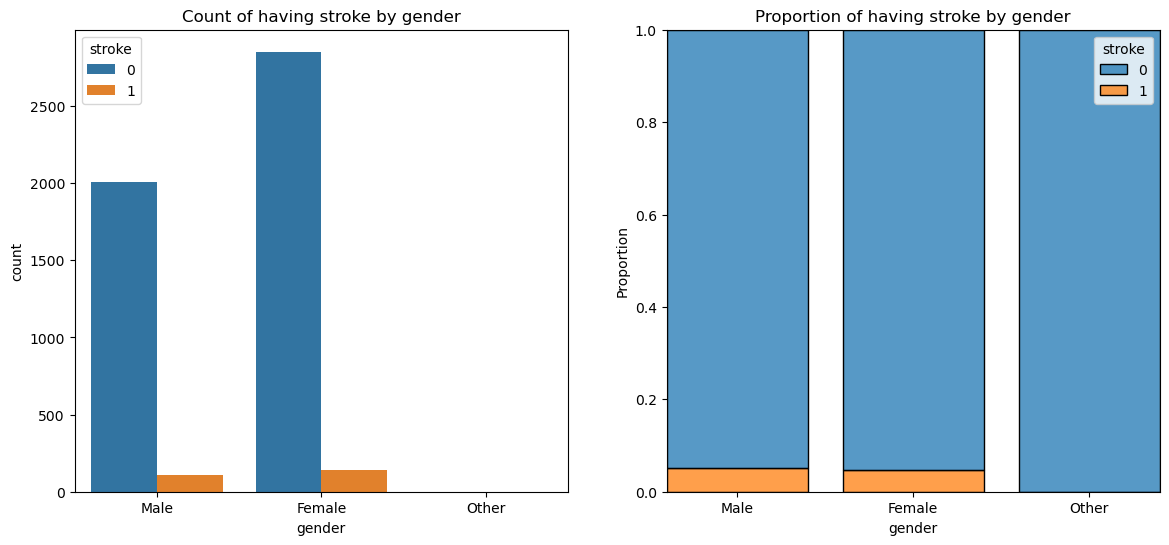

In [18]:
myFunc.my_plots(
    df,
    "gender",
    "stroke",
    "Count of having stroke by gender",
    "Proportion of having stroke by gender",
)

In [19]:
df.groupby("gender")["age"].agg(["mean", "median"])

,mean,median
gender,,
Female,43.76,44.00
Male,42.48,46.00
Other,26.00,26.00


We may see, that we have more Females in our data set, but proportion is the same for both genders.  
**Conclusion**: The occurrence of a stroke is not influenced by one's gender.

**Hypertension**

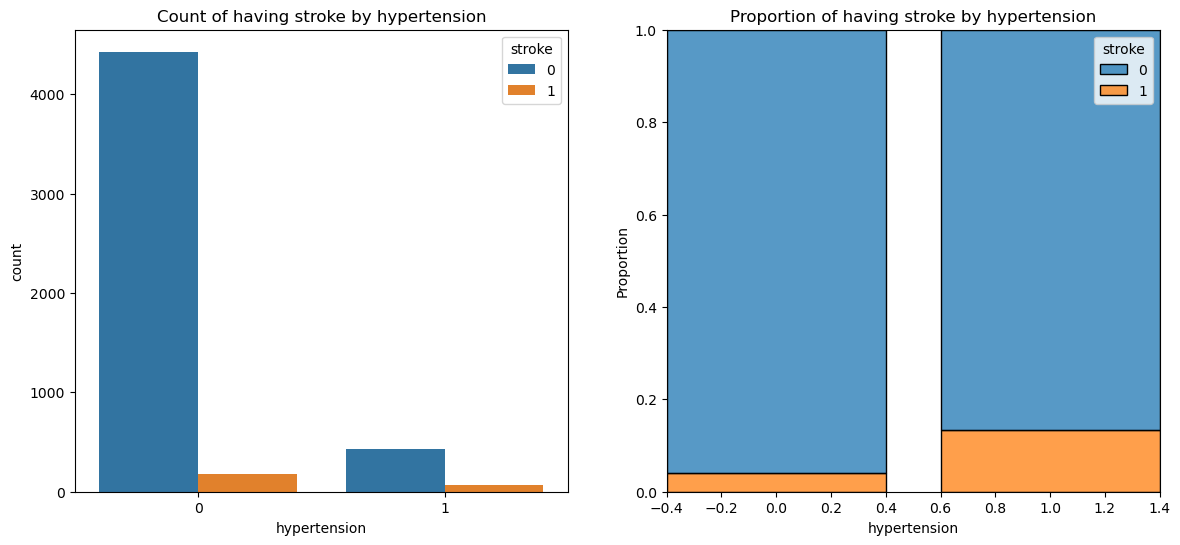

In [20]:
myFunc.my_plots(
    df,
    "hypertension",
    "stroke",
    "Count of having stroke by hypertension",
    "Proportion of having stroke by hypertension",
)

In [21]:
df.groupby("hypertension")["age"].agg(["mean", "median"])

,mean,median
hypertension,,
0,41.17,42.00
1,62.24,63.00


**Conclusion**: The likelihood of experiencing a stroke is higher among patients with hypertension, this may be also because of older age.

**Heart_disease**

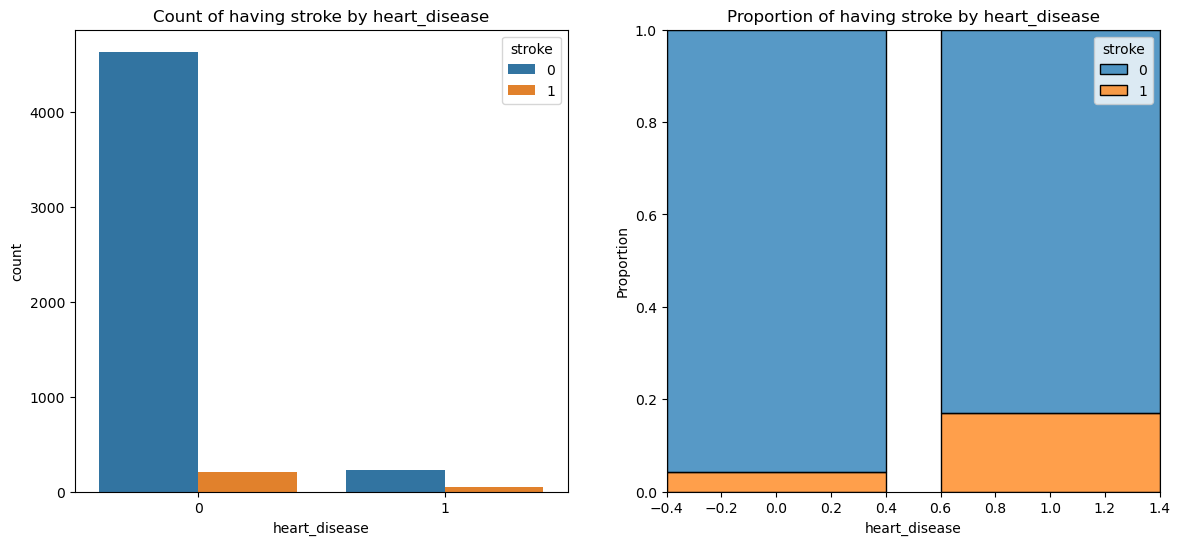

In [22]:
myFunc.my_plots(
    df,
    "heart_disease",
    "stroke",
    "Count of having stroke by heart_disease",
    "Proportion of having stroke by heart_disease",
)

In [23]:
df.groupby("heart_disease")["age"].agg(["mean", "median"])

,mean,median
heart_disease,,
0,41.80,43.00
1,68.19,71.00


**Conclusion**: The likelihood of experiencing a stroke is higher among patients with heart_disease. The main couse can be because of older age.

**Ever_married**

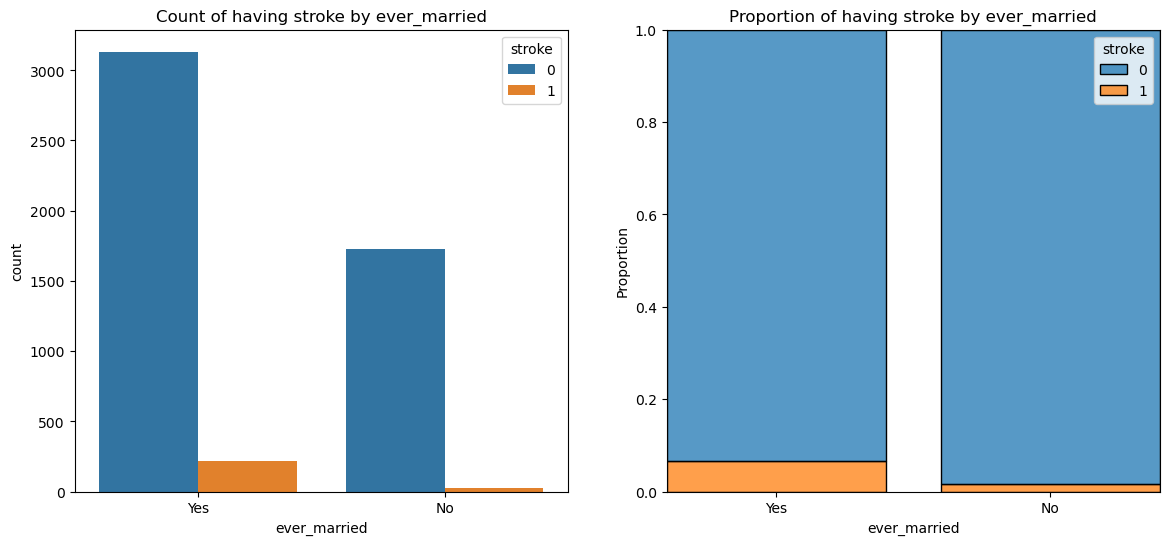

In [24]:
myFunc.my_plots(
    df,
    "ever_married",
    "stroke",
    "Count of having stroke by ever_married",
    "Proportion of having stroke by ever_married",
)

In [25]:
df.groupby("ever_married")["age"].agg(["mean", "median"])

,mean,median
ever_married,,
No,22.01,18.00
Yes,54.34,54.00


**Conclusion**: The likelihood of experiencing a stroke is higher among ever married patients, because thease people are older.

**Work type**

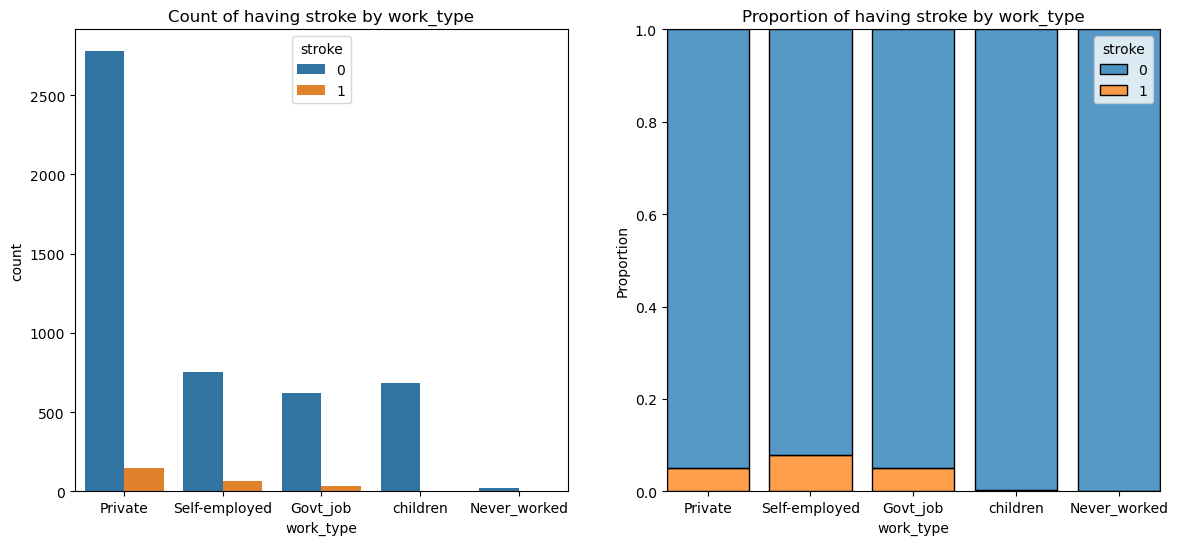

In [26]:
myFunc.my_plots(
    df,
    "work_type",
    "stroke",
    "Count of having stroke by work_type",
    "Proportion of having stroke by work_type",
)

In [27]:
df.groupby("work_type")["age"].agg(["mean", "median"])

,mean,median
work_type,,
Govt_job,50.88,51.00
Never_worked,16.18,16.00
Private,45.50,45.00
Self-employed,60.20,63.00
children,6.84,6.00


**Conclusion**: The likelihood of experiencing a stroke is higher among ever patients, who are self-employed, and again we see correlation with age.

**Residence_type**

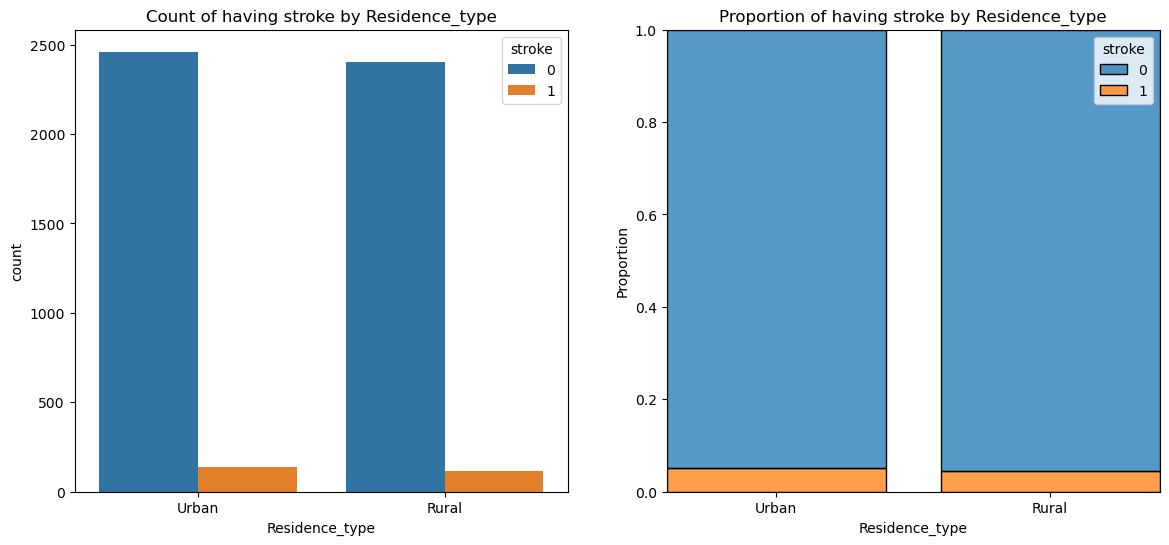

In [28]:
myFunc.my_plots(
    df,
    "Residence_type",
    "stroke",
    "Count of having stroke by Residence_type",
    "Proportion of having stroke by Residence_type",
)

In [29]:
df.groupby("Residence_type")["age"].agg(["mean", "median"])

,mean,median
Residence_type,,
Rural,42.90,44.00
Urban,43.54,45.00


**Conclusion**: The occurrence of a stroke is not influenced by residence type.

**Smoking status**

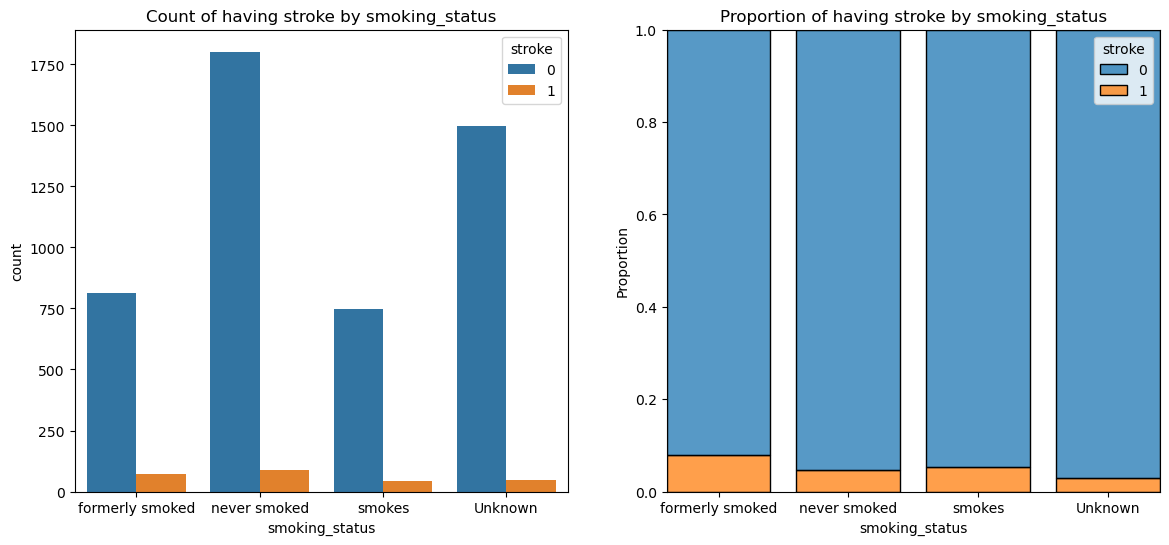

In [30]:
myFunc.my_plots(
    df,
    "smoking_status",
    "stroke",
    "Count of having stroke by smoking_status",
    "Proportion of having stroke by smoking_status",
)

In [31]:
df.groupby("smoking_status")["age"].agg(["mean", "median"])

,mean,median
smoking_status,,
Unknown,30.23,23.00
formerly smoked,54.93,57.00
never smoked,46.74,47.00
smokes,47.10,47.00


Even though the proportion of former smokers is highest, it's essential to consider that this group has the highest average age. It appears that smoking is not a significant factor in stroke risk.

**Age**

In [32]:
df["age_bins"] = pd.cut(
    x=df["age"],
    bins=[0, 20, 40, 60, 80, 100],
    labels=["0-20", "21-40", "41-60", "61-80", "81-100"],
)

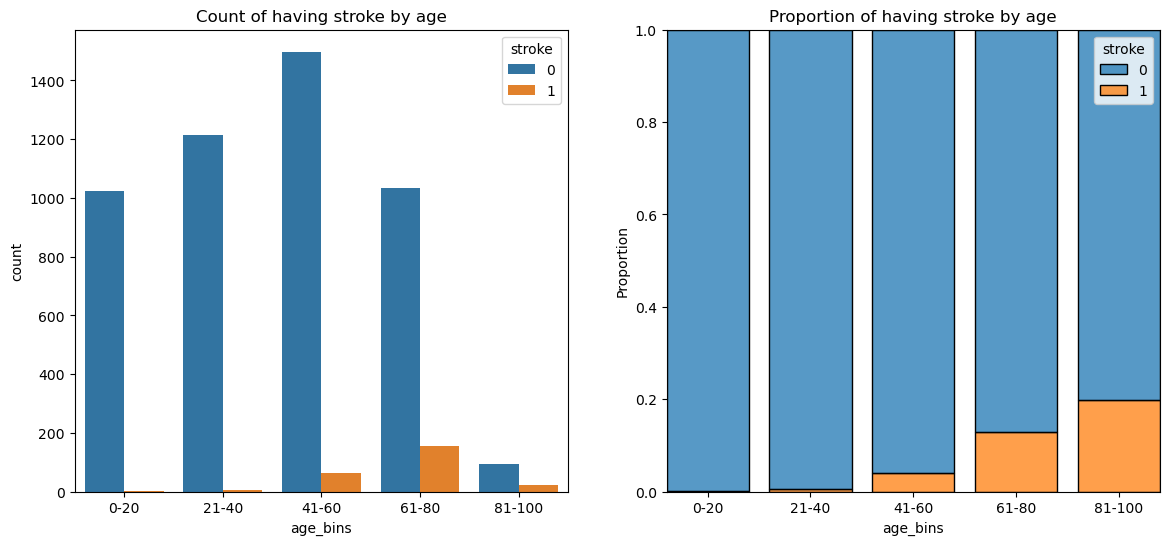

In [33]:
myFunc.my_plots(
    df,
    "age_bins",
    "stroke",
    "Count of having stroke by age",
    "Proportion of having stroke by age",
)

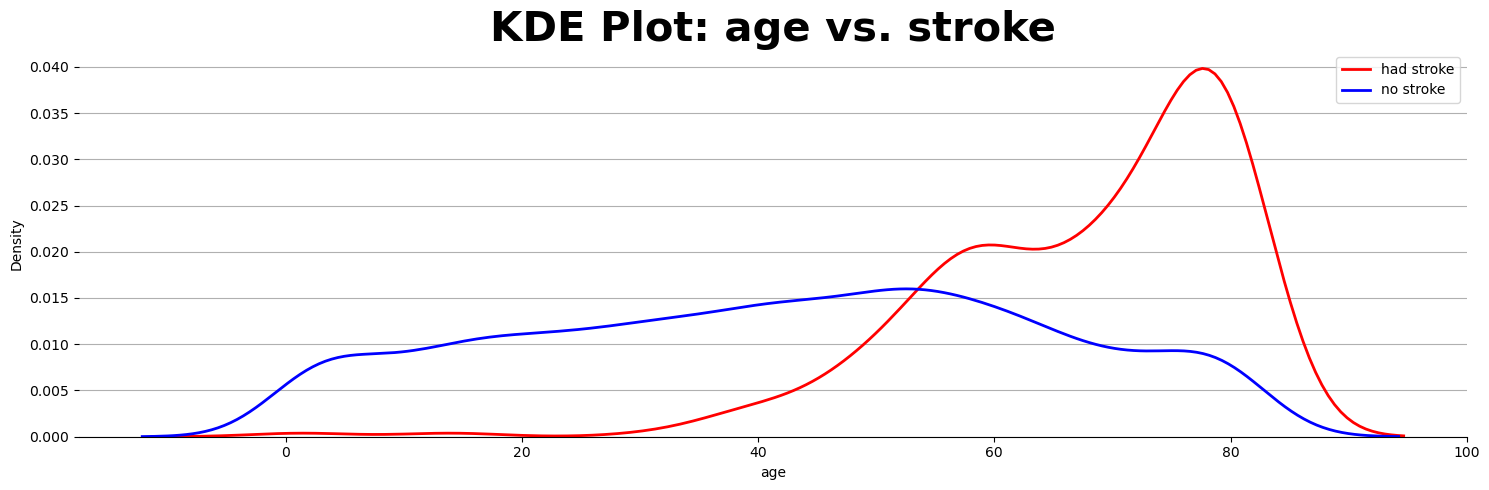

In [34]:
myFunc.plot_kde(df, "age", "stroke")

**Conclusion** Stroke cases occur more frequently as people age. The risk begins to increase around the age of 35 and accelerates significantly with advancing age.

**Average glucose level**

In [35]:
df["avg_glucose_level_bins"] = pd.cut(
    x=df["avg_glucose_level"],
    bins=[0, 100, 200, 300, 400],
    labels=["0-100", "101-200", "201-300", "301-400"],
)

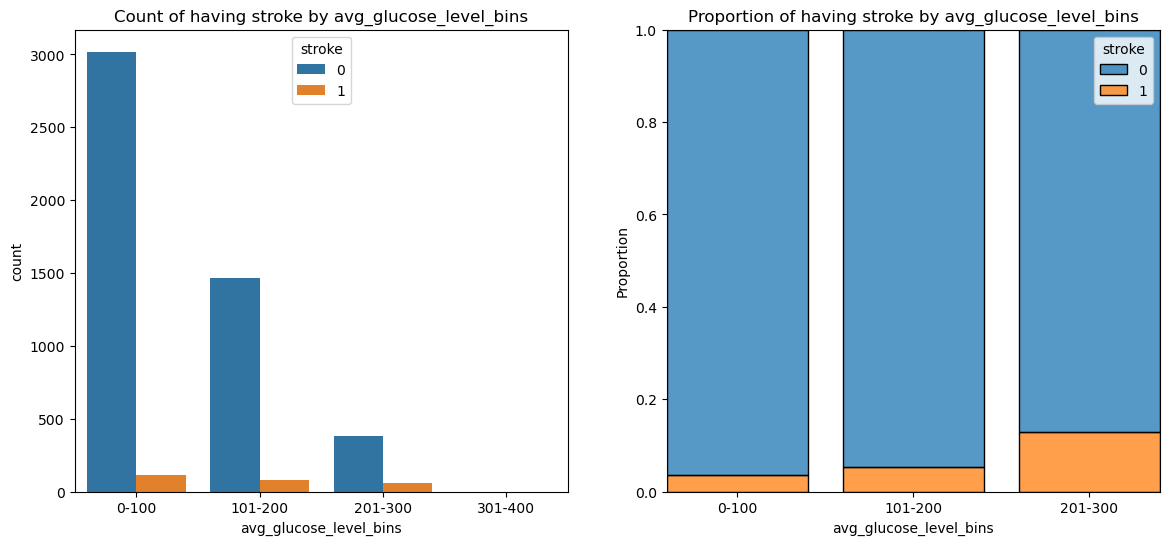

In [36]:
myFunc.my_plots(
    df,
    "avg_glucose_level_bins",
    "stroke",
    "Count of having stroke by avg_glucose_level_bins",
    "Proportion of having stroke by avg_glucose_level_bins",
)

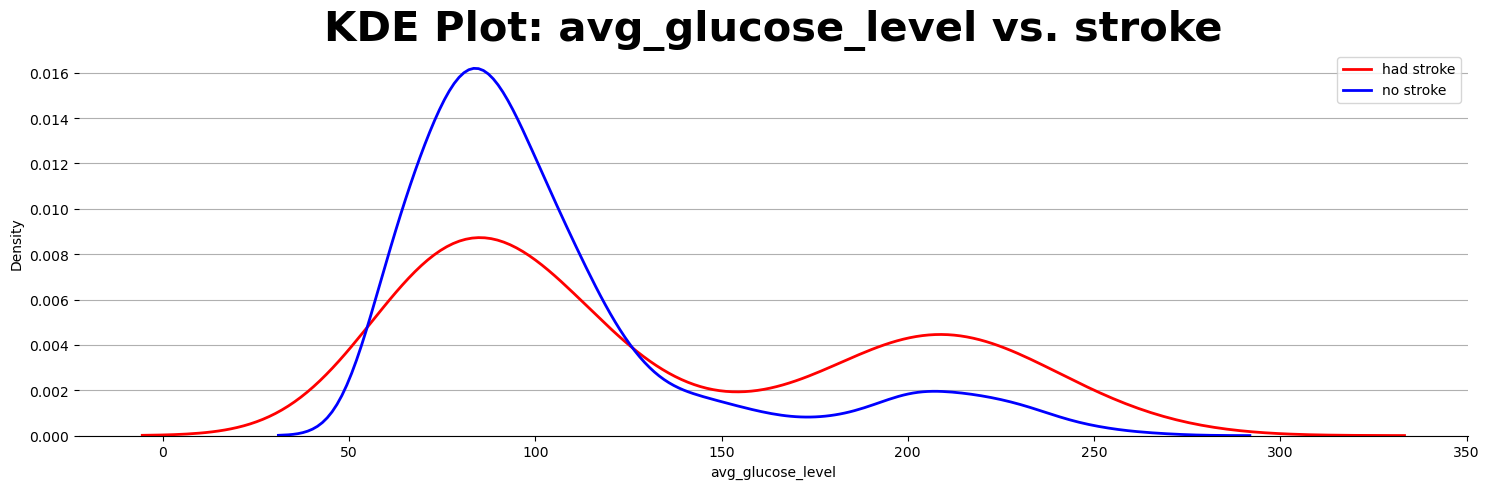

In [37]:
myFunc.plot_kde(df, "avg_glucose_level", "stroke")

In [38]:
df.groupby("avg_glucose_level_bins")["age"].agg(["mean", "median"])

,mean,median
avg_glucose_level_bins,,
0-100,41.29,42.00
101-200,41.98,44.00
201-300,61.63,63.00
301-400,NaN,NaN


**Conclusion** As the level of glucose increases, starting from 125 mg/dl, the chances of experiencing a stroke also increase.

**Bmi**

In [39]:
df["bmi_bins"] = pd.cut(
    x=df["bmi"],
    bins=[0, 10, 20, 30, 40, 50, 60],
    labels=["0-10", "11-20", "21-30", "31-40", "41-50", "51-60"],
)

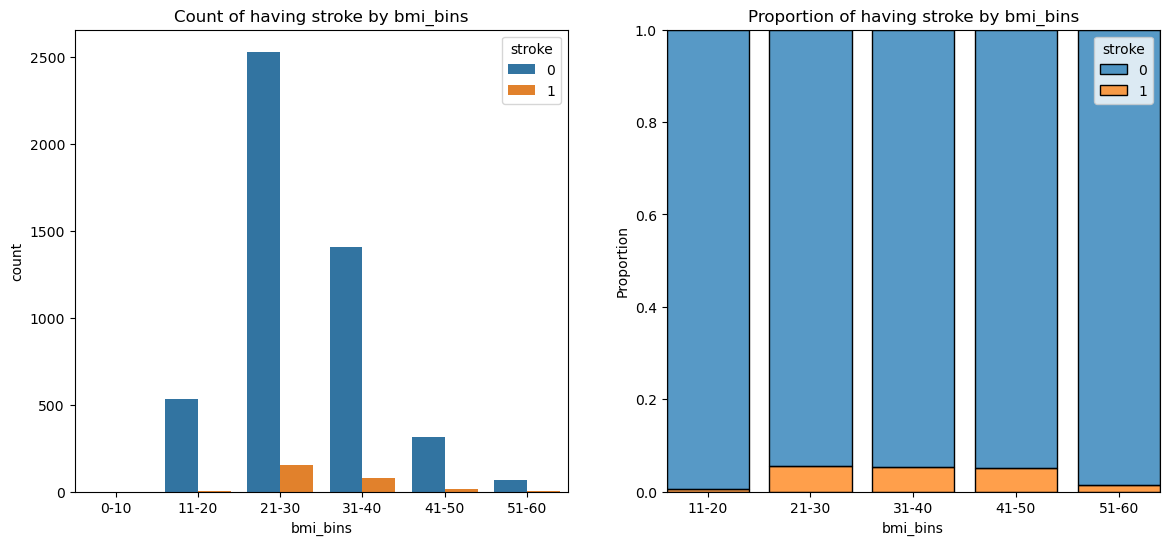

In [40]:
myFunc.my_plots(
    df,
    "bmi_bins",
    "stroke",
    "Count of having stroke by bmi_bins",
    "Proportion of having stroke by bmi_bins",
)

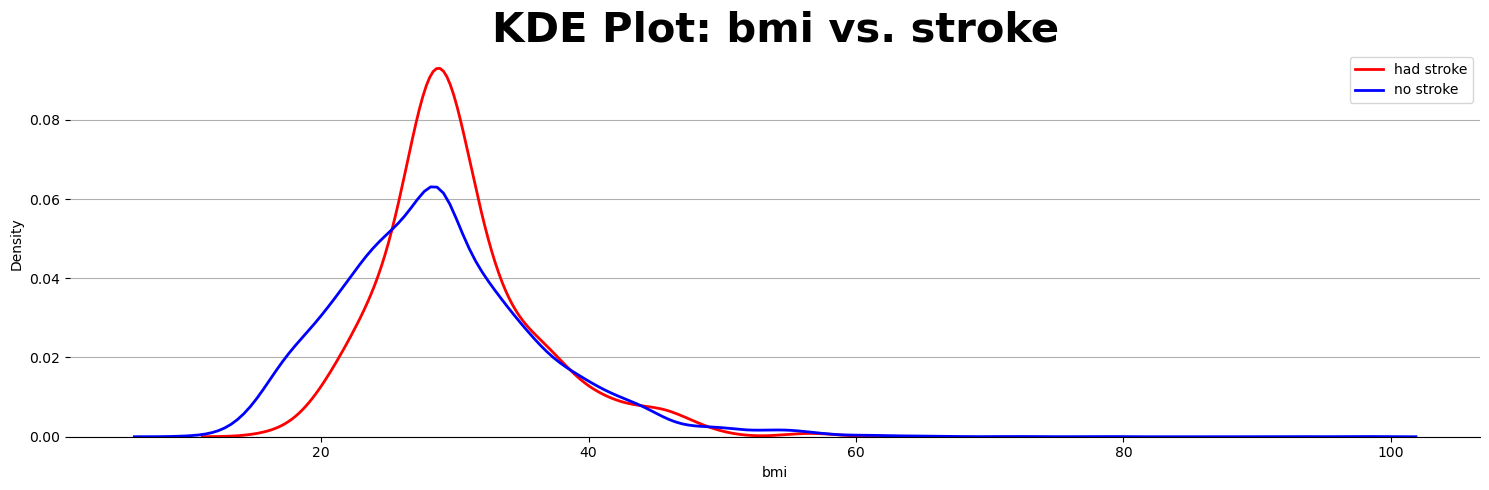

In [41]:
myFunc.plot_kde(df, "bmi", "stroke")

In [42]:
df.groupby("bmi_bins")["age"].agg(["mean", "median"])

,mean,median
bmi_bins,,
0-10,NaN,NaN
11-20,13.94,7.00
21-30,44.53,45.00
31-40,50.68,52.00
41-50,46.19,46.00
51-60,46.39,46.50


We may see peak of stroke cases in bmi 30-40 because there we have the oldest people in our data set. But comparing same age people, we may see, that stroke is more common in overwight people. 

In [43]:
df = df.drop(["age_bins", "avg_glucose_level_bins", "bmi_bins"], axis=1)

### Statistical inference

During the exploratory data analysis (EDA), the most significant disparities were identified in the mean average glucose level and the proportion of individuals with heart disease when comparing the two groups of those who had suffered a stroke and those who had not. To ascertain their statistical significance, we will now proceed with appropriate statistical inference procedures.

#### Inferential statistical analysis

**Difference in proportions - heart disease** 
 
Let's see if the difference in proportions of patients, who had stroke, among having heart didease and not having heart desease is  statistically significant.

In [44]:
df_emp = df.groupby("heart_disease")[["stroke"]].agg(["sum", "count"])
df_emp = df_emp.droplevel(0, axis=1).reset_index()
df_emp["proportion"] = df_emp["sum"] / df_emp["count"]
df_emp

,heart_disease,sum,count,proportion
0,0,202,4834,0.04
1,1,47,276,0.17


**Research question**

Is the difference in proportions of patients with stroke who have heart disease and patients with stroke who do not have heart disease statistically significant?

**Population**  
Johns Hopkins Hospital patients  
0 -  patients who had stroke and had no heart deasease (202)  
1 -  patients who had stroke and had heart deasease (47)

**Parameter of interest** 
Difference in population proportions:  
p(0) - p(1)

**Power of the test** ($1 - \beta$) - 0.8 

**Significance level**: 0.05

**Null Hypothesis:** p0 - p1 => 0  (there is no difference)

**Alternative Hypothesis:** p0 - p1 < 0

One tail testing, p(1) is larger so the difference is < 0

**Assumptions**:
1. Our samples are independent from each other.

**Preliminary power test analysis**  

Let's get the needed sample size to avoid p-hacking.

In [45]:
myFunc.power_test_one_tail(0.04, 0.17)

 Required sample size:79


I have a much smaller sample size, so I should be aware of possible p-hacking.

In [46]:
myFunc.calc_pi_t_test_proportions(df_emp)

Pi value for diff in proportions using t test:2.6000548836898707e-22


We calculated a p-value of approximately 2.6 e-22, which falls below our alpha value of 0.05. As a result, **we have evidence to reject the null hypothesis**.  

We can conclude that a significant distinction exists between the population proportions of patients with stroke among individuals with heart disease and those without heart disease. Individuals having heart disease are showing a greater inclination to have a stroke.

**Confidence intervals**

1. Confidence level of 95%.
2. Significant level alpha = 0.05

In [47]:
df_emp

,heart_disease,sum,count,proportion
0,0,202,4834,0.04
1,1,47,276,0.17


In [48]:
myFunc.calc_confid_intervals(df_emp)

Confidence interval is   -0.24 - -0.02


The 95% confidence interval above shows that any value for the difference of population proportions is lying between -0.24 and -0.02. Our estimated difference was -0.13, which falls within this interval. Notably, the value 0 does not fall within this range.
Hence, the null hypothesis, which suggests that the difference between proportions could be 0, has been appropriately rejected.

Conclusion: Johns Hopkins Hospital patients who had no heart deasease are 2% - 24 % less likely to get stroke compared to patients who had heart deasease.

### Difference in means - glucose levels
 
Let's see if the difference in means of glucose levels, among customers who had stroke and did not is statistically significant.

**Research question**  
When considering patients, who had stroke and who hadn't, is the difference in means of glucose level is statistically significant?

**Population**
The Johns Hopkins Hospital's patients.

**Population subgroup**
People, who had stroke (1)
People, who had not stroke (0)

**Parameter of Interest**: difference in population subgroups mean glucose level.

**Explanation**:
$\mu$ (1)- mean glucose level of people, who had stroke

$\mu$ (0) - mean glucose level of people, who had not stroke

**Power of the test** ($1 - \beta$) - This represents the probability to find a statistical difference between two groups when a difference is actually present. This is usually set at 0.8.

**Significance level $\alpha$** : 0.05

**Confidence level** = 95%

**Null Hypothesis:** H(O): $\mu$ (1) -$\mu$ (0) = 0

**Alternative Hypothesis:** $\mu$ (1) - $\mu$ (0) > 0 

This will be a *one tail* testing.

**Assumptions**:
1. We assume that groups are simple random samples. Samples are independent one from each other.
2. The distribution of both subpopulations are not fully normal, but as we have a lot of abservations, we can count on Central limit theorem.
3. We can not use pooled approach, because std is not similar.

The $\alpha$ value is a threshold we set, by which we say "if the probability of observing a result as extreme or more ($p$-value) is lower than $\alpha$, then we reject the null hypothesis". 


In [49]:
for_testing = df.groupby("stroke")["avg_glucose_level"].agg(["mean", "std", "count"])
for_testing

,mean,std,count
stroke,,,
0,104.80,43.85,4861
1,132.54,61.92,249


Two-sample T-Test with unequal variance can be applied when  
(1) the samples are normally distributed (we count on CLT)  
(2) the standard deviation of both populations are unknown and assume to be unequal   
(3) sample is sufficiently large (over 30).

In [50]:
n1 = for_testing.iloc[1][2]
mu1 = for_testing.iloc[1][0]
sd1 = for_testing.iloc[1][1]
print(n1, mu1, sd1)

249.0 132.54473895582328 61.9210555806822


In [51]:
n0 = for_testing.iloc[0][2]
mu0 = for_testing.iloc[0][0]
sd0 = for_testing.iloc[0][1]
print(n0, mu0, sd0)

4861.0 104.79551326887471 43.84606850027663


In [52]:
# Mean difference
mean_diff = mu1 - mu0
# Estimated std
est_std = np.sqrt((sd1**2 + sd0**2) / 2)

In [53]:
# Power of the test calculation
effect_size = mean_diff / est_std
required_n = sms.NormalIndPower().solve_power(
    effect_size, power=0.8, alpha=0.05, ratio=1, alternative="larger"
)
required_n = ceil(required_n)
print(required_n)

47


Our sample sizes are bigger than 47, so Pi hacking should be avoided.

In [54]:
statistics, p_value = stats.ttest_ind(
    df.loc[df["stroke"] == 1]["avg_glucose_level"],
    df.loc[df["stroke"] == 0]["avg_glucose_level"],
    equal_var=False,  # Welch’s t-test, variance is not equal
    alternative="greater",
)
print(f"T-statistic: {statistics}, p-value: {p_value}")

T-statistic: 6.982411744792963, p-value: 1.2007183281848838e-11


Conclusions:  
The difference between sample means of avg_glucose_level, are above the hypothesized 0 value by more than 7 estimated standard errors.  
P-value is smaller then alpha 0,05, so we reject our null hypothesis.  
Mean of avg_glucose_level is significantly higher of patients, who had stroke.

In [55]:
# Calculation of conficence intervals:

# Margin of error
Margin1 = sd1 / np.sqrt(n1)
Margin0 = sd0 / np.sqrt(n0)
sem_diff = np.sqrt(Margin1**2 + Margin0**2)

lcb = mean_diff - 1.96 * sem_diff
ucb = mean_diff + 1.96 * sem_diff
print(
    f"Confidence interval is between {lcb.round(1)} and {ucb.round(1)}, estimated difference: {mean_diff.round(1)}"
)

Confidence interval is between 20.0 and 35.5, estimated difference: 27.7


With 95% confidence, the difference in means of glucose levels in these groups of people is estimated to fall between 20 and 35.5 mg/dl. Since the confidence interval does not include 0 and the calculated difference in sample means falls within this interval, we can conclude that there is a statistically significant difference in mean glucose levels between the two groups.

**Categorical data transformation for correlation**

In this chapter we will tranform all categrical features into numbers.

In [56]:
df_corr = myFunc.categorical_to_binary(df, "Yes", "No")
df_corr = myFunc.categorical_to_binary(df_corr, "Urban", "Rural")
df_corr.replace(
    {
        "smoking_status": {
            "Unknown": 0,
            "never smoked": 1,
            "formerly smoked": 2,
            "smokes": 3,
        },
        "gender": {
            "Other": 2,
            "Female": 1,
            "Male": 0,
        },
        "work_type": {
            "Private": 3,
            "Self-employed": 4,
            "Govt_job": 2,
            "children": 1,
            "Never_worked": 0,
        },
    },
    inplace=True,
)
df_corr.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.00,0,1,1,3,1,228.69,36.60,2,1
1,1,61.00,0,0,1,4,0,202.21,28.89,1,1
2,0,80.00,0,1,1,3,0,105.92,32.50,1,1
3,1,49.00,0,0,1,3,1,171.23,34.40,3,1
4,1,79.00,1,0,1,4,0,174.12,24.00,1,1


Text(0.5, 1.0, 'Features Correlation Heatmap')

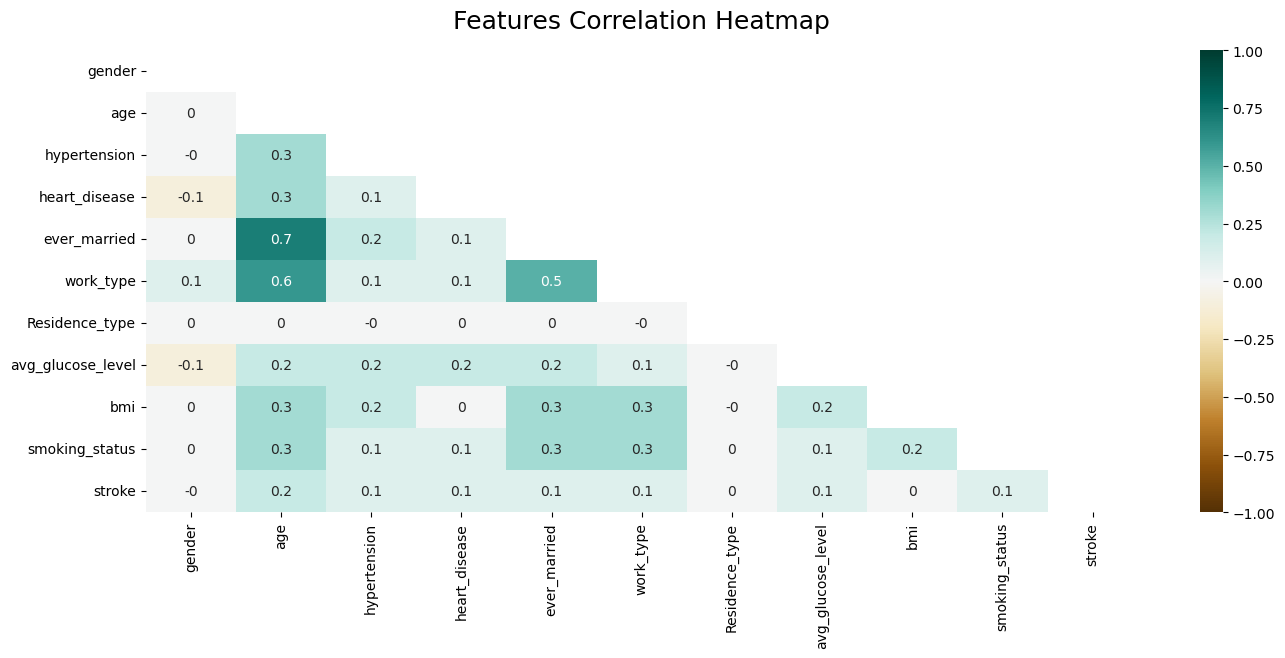

In [57]:
plt.figure(figsize=(16, 6))
mask1 = np.triu(np.ones_like(df_corr.corr(), dtype=bool))
heatmap = sns.heatmap(
    df_corr.corr().round(1), mask=mask1, vmin=-1, vmax=1, annot=True, cmap="BrBG"
)
heatmap.set_title("Features Correlation Heatmap", fontdict={"fontsize": 18}, pad=16)

Age looks like one of the most important feature, it has best correlation with target variable stroke.

In [58]:
X_temp = df_corr.drop(["stroke", "work_type"], axis=1)
Xtemp_constant = add_constant(X_temp)


def calc_vif(df_result):
    vif = pd.DataFrame()
    vif["variables"] = df_result.columns
    vif["VIF"] = [
        variance_inflation_factor(df_result.values, i)
        for i in range(df_result.shape[1])
    ]
    return vif

In [59]:
calc_vif(Xtemp_constant)

,variables,VIF
0,const,21.34
1,gender,1.01
2,age,2.18
3,hypertension,1.11
4,heart_disease,1.11
5,ever_married,1.94
6,Residence_type,1.00
7,avg_glucose_level,1.10
8,bmi,1.19
9,smoking_status,1.13


Age and ever_married VIF coefiient is less than 5, so we will not drop ever married feature from model. We will use all features for modeling, because there are no strong multicoliniarity.

## Conclusions:

**About dataset:**

- No duplicates were found
- Missing BMI values were filled with the mean value. 
- There were no unusual values detected in the categorical features.
- This dataset has no outliers.
- This dataset is imbalanced. We have 5110 observations, of which 249 had a stroke.

**The likelihood of experiencing a stroke is higher among patients:**

- Age appears to be the most significant feature for predicting stroke, showing the strongest correlation with the target feature. Moreover, using age as a predictor can help explain other feature dependencies with stroke cases:
    - Hypertension: This association may also be linked to older age.
    - Heart disease: The primary factor contributing to this could be older age.
    - Ever-married patients: This likelihood is higher in this group, likely because they tend to be older.
    - Self-employed patients: Again, this correlates with age.
- Another valuable predictor is the level of glucose, especially when it reaches 125 mg/dl or more.


**The occurrence of a stroke is not influenced by:**
- residence type
- gender
